In [1]:
import mido
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib import colormaps as cm

from tqdm.auto import tqdm

## Load the MIDI file containing the motif

In [2]:
mid = mido.MidiFile("data/violin_phase_noE.mid")
mid

MidiFile(type=0, ticks_per_beat=480, tracks=[
  MidiTrack([
    MetaMessage('channel_prefix', channel=0, time=0),
    MetaMessage('track_name', name='violin_phase.mp3', time=0),
    MetaMessage('instrument_name', name='Steinway Grand Piano', time=0),
    MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
    MetaMessage('key_signature', key='C', time=0),
    MetaMessage('smpte_offset', frame_rate=25, hours=0, minutes=0, seconds=0, frames=0, sub_frames=0, time=0),
    MetaMessage('set_tempo', tempo=416667, time=0),
    Message('program_change', channel=0, program=0, time=0),
    Message('note_on', channel=0, note=61, velocity=17, time=0),
    Message('note_off', channel=0, note=61, velocity=64, time=120),
    Message('note_on', channel=0, note=66, velocity=19, time=120),
    Message('note_off', channel=0, note=66, velocity=64, time=120),
    Message('note_on', channel=0, note=69, velocity=16, time=120),
    Message('not

In [3]:
def midi_to_timeseries(midi_file):
    # Load the MIDI file
    mid = mido.MidiFile(midi_file)

    # Initialize lists to store time and note information
    times = []
    notes = []
    current_time = 0

    # Iterate through the messages in the MIDI file
    for msg in mid:
        current_time += msg.time  # Increment the current time
        if msg.type == "note_on" and msg.velocity > 0:  # Only consider note_on events
            times.append(current_time)
            notes.append(msg.note)  # Store the MIDI note number

    # Convert lists to numpy arrays for easier manipulation
    times = np.array(times)
    notes = np.array(notes)

    # Create a time series (you can format this however you like)
    # time_series = np.column_stack((times, notes))

    return times, notes


midi_file = "data/violin_phase_noE.mid"  # Replace with your MIDI file path
times, notes = midi_to_timeseries(midi_file)

In [4]:
notes

array([61, 66, 69, 68, 71, 61, 66, 69, 68, 71])

In [5]:
times = (times / times[1]).astype(int) * 10
times

array([  0,  10,  20,  30,  40,  70,  80,  90, 100, 110])

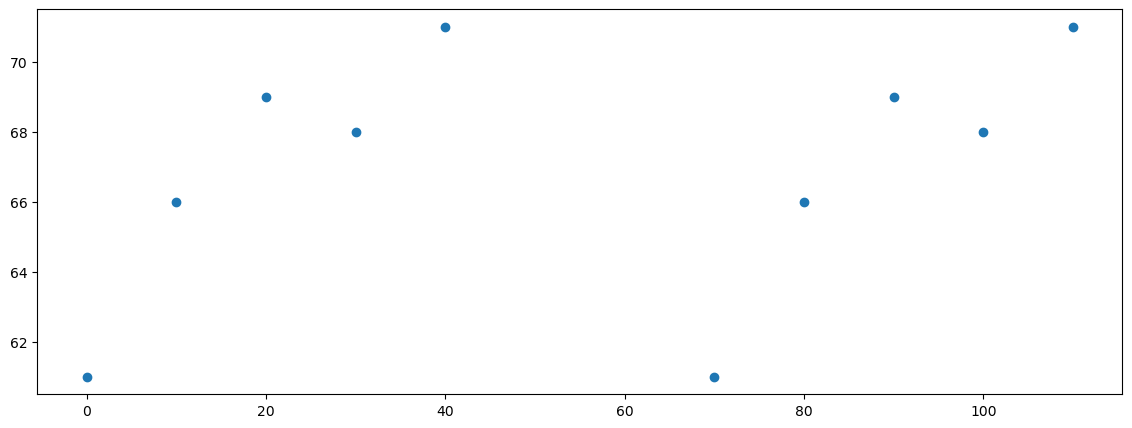

In [6]:
plt.figure(figsize=(14, 5))
plt.scatter(times[:100], notes[:100])

In [7]:
np.unique(notes)

array([61, 66, 68, 69, 71])

## Sample points uniformly in between notes

In [8]:
from scipy.interpolate import interp1d

# Create new evenly spaced time points
new_times = np.linspace(
    0, 120, num=120, endpoint=False
)  # Adjust 'num' for more or fewer points

# Interpolation function
interp_func = interp1d(times, notes, kind="previous", fill_value="extrapolate")

# Get interpolated values
new_values = interp_func(new_times)

# Output the new times and values
print(new_times)
print(new_values)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119.]
[61. 61. 61. 61. 61. 61. 61. 61. 61. 61. 66. 66. 66. 66. 66. 66. 66. 66.
 66. 66. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 68. 68. 68. 68. 68. 68.
 68. 68. 68. 68. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71.
 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 61. 61.
 61. 61. 61. 61. 61. 61. 61. 61. 66. 66. 66. 66. 66. 66. 66. 66. 66. 66.
 69. 69. 69. 69. 69. 69. 

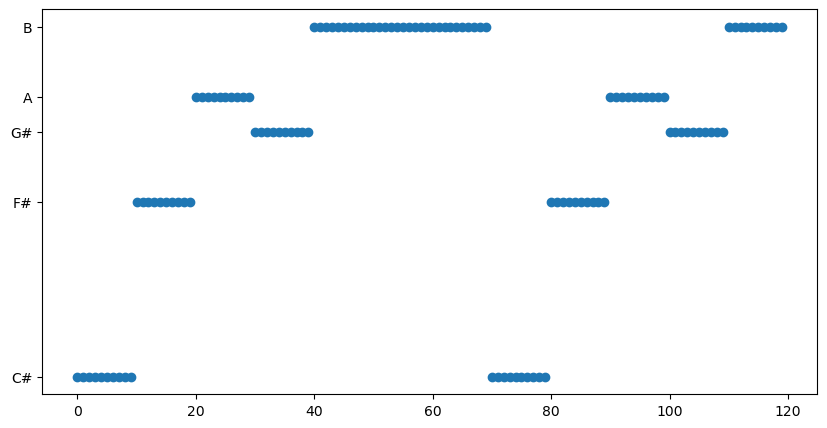

In [9]:
plt.figure(figsize=(10, 5))
plt.scatter(new_times, new_values)
plt.yticks(ticks=np.unique(notes), labels=["C#", "F#", "G#", "A", "B"])
plt.show()

In [10]:
pd.Series(new_values).value_counts()

71.0    40
61.0    20
66.0    20
69.0    20
68.0    20
Name: count, dtype: int64

## Create timeseries

In [11]:
## create timeseries by copying and shifting the motif
all_times = []
all_values = []
shift = 2
for i in range(61):
    # original
    all_values += new_values.tolist()
    all_times += (new_times + 120 * i).tolist()

    # shifted
    # if i > 0:
    all_values += new_values.tolist()
    all_times += (new_times + (120 + shift) * i).tolist()

all_times = np.array(all_times, dtype=int)
all_values = np.array(all_values)

all_values = all_values[np.argsort(all_times)]
all_times = np.sort(all_times)

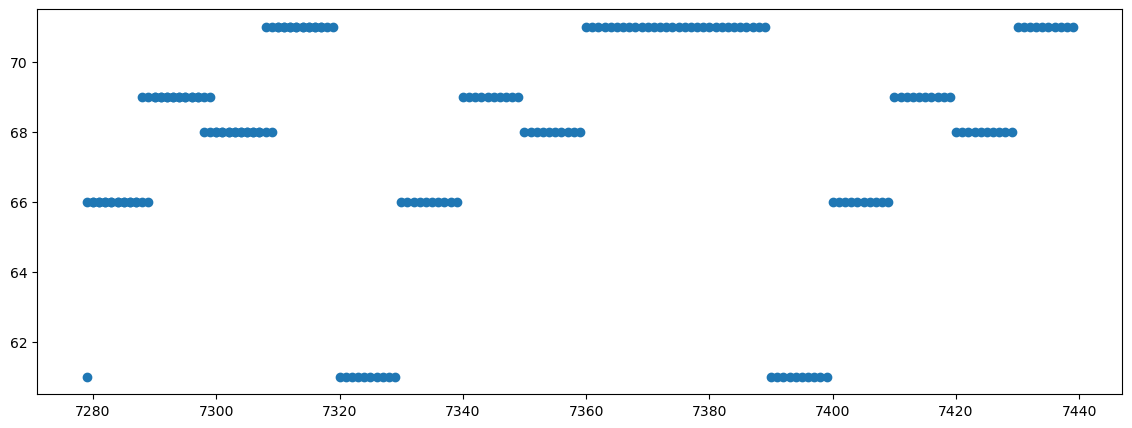

In [12]:
## visualize the tail of the timeseries
plt.figure(figsize=(14, 5))
plt.scatter(all_times[-200:], all_values[-200:])

## Create a 5dimensional timeseries, one dimension per note

In [13]:
notes_dict = {n: i for i, n in enumerate(np.unique(notes))}
notes_dict

{61: 0, 66: 1, 68: 2, 69: 3, 71: 4}

In [14]:
timeseries_5d = {i: np.zeros(5) for i in all_times}
for t, v in zip(all_times, all_values):
    timeseries_5d[t][notes_dict[v]] = 1

In [15]:
len(timeseries_5d)

7440

In [16]:
list(timeseries_5d.values())[:10]

[array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.])]

(5, 7440)


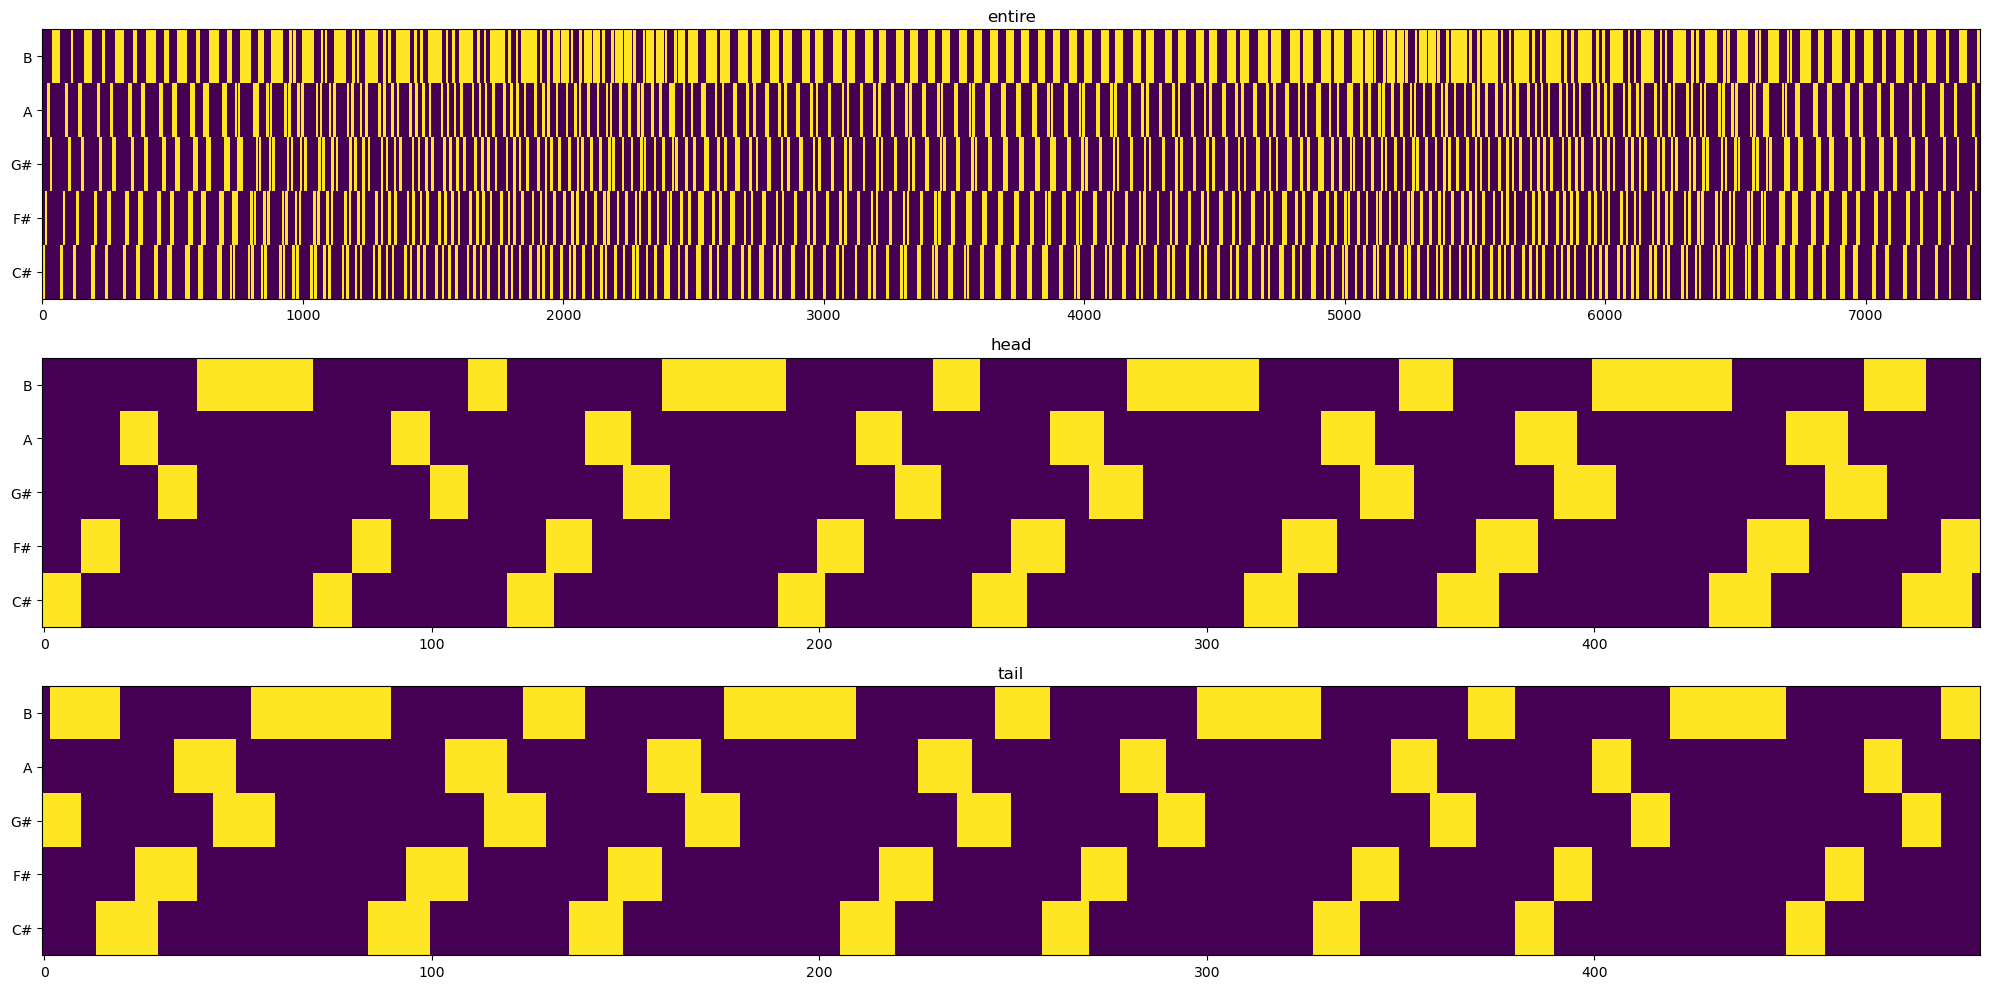

In [17]:
# visualizing it

img = np.array(list(timeseries_5d.values())).T
print(img.shape)

fig, axs = plt.subplots(nrows=3, figsize=(20, 10))

# entire
axs[0].imshow(img, aspect="auto", interpolation="none", origin="lower")
axs[0].set_title("entire")

# head
axs[1].imshow(img[:, :500], aspect="auto", interpolation="none", origin="lower")
axs[1].set_title("head")

# tail
axs[2].imshow(img[:, -500:], aspect="auto", interpolation="none", origin="lower")
axs[2].set_title("tail")

for ax in axs:
    ax.set_yticks(ticks=range(5), labels=["C#", "F#", "G#", "A", "B"])
plt.tight_layout()
plt.show()

## Time-delay embdedding

In [18]:
# we have 5 univariate time series of duration 7440:
X = np.array(list(timeseries_5d.values()), dtype=float)
X.shape

(7440, 5)

In [19]:
## repeat it so that we can have long windows in the time-dealy embedding
X = np.tile(X, (10, 1))
X.shape

(74400, 5)

In [20]:
def time_delay_embedding(data, dimension, delay):
    """
    Create a time delay embedding of the given data.

    Parameters:
    - data: 1D array-like, the input time series data
    - dimension: int, the embedding dimension
    - delay: int, the time delay

    Returns:
    - embedded: 2D array, the time delay embedded data
    """
    n = len(data)

    if dimension * delay > n:
        raise ValueError(
            "Dimension and delay are too large for the length of the data."
        )

    # Create the embedded array
    embedded = np.array(
        [
            data[i : i + dimension * delay : delay].flatten()
            for i in range(n - dimension * delay + 1)
        ]
    )

    return embedded

In [21]:
X_te = time_delay_embedding(X, dimension=20, delay=1)
# X_te = time_delay_embedding(X, dimension=20, delay=200)
X_te.shape

(74381, 100)

In [22]:
len(np.unique(X_te, axis=1))

74381

## BallMapper

In [23]:
from pyballmapper import BallMapper
from pyballmapper.plotting import graph_GUI

EPS = 2
EPS = 3

bm = BallMapper(
    X=X_te[:7440],  # we stop when the song stops
    eps=EPS,
    verbose="tqdm",
)

Finding vertices...


  0%|          | 0/7440 [00:00<?, ?it/s]

196 vertices found.
Computing points_covered_by_landmarks...


  0%|          | 0/196 [00:00<?, ?it/s]

Running BallMapper 
Finding edges...


0it [00:00, ?it/s]

Creating Ball Mapper graph...
Done


In [24]:
bm.add_coloring(
    coloring_df=pd.DataFrame(data={"time": all_times}),
    # custom_function=np.min
)

In [25]:
# this cell allows for bokeh plots to be displayed inside jupyter notebooks
from bokeh.io import output_notebook
from bokeh.plotting import show

output_notebook()

Loading BokehJS ...

In [26]:
my_palette = cm.get_cmap("viridis")
time_gui = graph_GUI(
    bm.Graph,
    my_palette,
)
time_gui.color_by_variable("time")
time_gui.add_colorbar(
    num_ticks=100,
    low=np.min([bm.Graph.nodes[n]["time"] for n in bm.Graph.nodes]),
    high=np.max([bm.Graph.nodes[n]["time"] for n in bm.Graph.nodes]),
)

show(time_gui.plot)

color by variable time 
MIN_VALUE: 1737.400, MAX_VALUE: 2160.040


## GIF

### time

In [ ]:
!mkdir gif_time

In [ ]:
pos = nx.spring_layout(bm.Graph, seed=42, iterations=100)

for i in tqdm(range(len(X_te[:7440]))):
    colors = np.zeros(len(X_te[:7440]))
    colors[i] = 1

    bm.add_coloring(
        coloring_df=pd.DataFrame(data={"time": colors}),
    )

    fig, ax = plt.subplots(figsize=(10, 10))
    bm.draw_networkx(
        coloring_variable="time",
        ax=ax,
        pos=pos,
        with_labels=False,
    )

    plt.title(i)
    plt.tight_layout()
    plt.savefig("gif_time/{:04d}.png".format(i))
    plt.close()

In [ ]:
## create video from gif and add the sound
## 40 frames per second is good for 120 bpm
!ffmpeg -framerate 40 -i gif_time/%04d.png -i data/violin_120bpm_62bars.m4a -c:v libx264 -pix_fmt yuv420p -movflags faststart -shortest output/output_time.mp4   

### trace

In [ ]:
!mkdir gif_trace

In [27]:
pos = nx.spring_layout(bm.Graph, seed=42, iterations=100)

M = 120 * 15

for i in tqdm(range(len(X_te[:7440]))):

    ## count how many times the node N has been visited in the last N times

    for n in bm.Graph.nodes:
        bm.Graph.nodes[n]["visits"] = 0
        for p in bm.Graph.nodes[n]["points covered"]:
            if (p <= i) and (p > i - M):
                bm.Graph.nodes[n]["visits"] += 1

    fig, ax = plt.subplots(figsize=(10, 10))
    bm.draw_networkx(
        coloring_variable="visits",
        # MIN_VALUE=0,
        # MAX_VALUE=min(M, i),
        ax=ax,
        pos=pos,
        with_labels=False,
    )

    plt.title(i)
    plt.tight_layout()
    plt.savefig("gif_trace/{:04d}.png".format(i))
    plt.close()

  0%|          | 0/7440 [00:00<?, ?it/s]

In [28]:
## create video from gif and add the sound
!ffmpeg -framerate 40 -i gif_trace/%04d.png -i data/violin_120bpm_62bars.m4a -c:v libx264 -pix_fmt yuv420p -movflags faststart -shortest output/output_trace.mp4   

ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with clang version 17.0.6
  configuration: --prefix=/Users/runner/miniforge3/conda-bld/ffmpeg_1728332276747/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --cc=arm64-apple-darwin20.0.0-clang --cxx=arm64-apple-darwin20.0.0-clang++ --nm=arm64-apple-darwin20.0.0-nm --ar=arm64-apple-darwin20.0.0-ar --disable-doc --enable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1728332276747/_build_env/bin/x86_64-apple-darwin13.4.0-clang --enable-neon --disable-gnutls --enable-libmp3lame --enable-libvpx --enable-libass --e

## 3d plot

In [29]:
layt = nx.spring_layout(bm.Graph, dim=3, iterations=800, seed=33)

N = len(layt)

Xn = [layt[k][0] for k in layt]  # x-coordinates of nodes
Yn = [layt[k][1] for k in layt]  # y-coordinates
Zn = [layt[k][2] for k in layt]  # z-coordinates
Xe = []
Ye = []
Ze = []
for e in bm.Graph.edges:
    Xe += [layt[e[0]][0], layt[e[1]][0], None]
    Ye += [layt[e[0]][1], layt[e[1]][1], None]
    Ze += [layt[e[0]][2], layt[e[1]][2], None]


import plotly.graph_objects as go

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=Xn,
            y=Yn,
            z=Zn,
            mode="markers",
            showlegend=False,
            # text=["{:.1f}".format(bm.Graph.nodes[n]["time"]) for n in bm.Graph.nodes],
            hoverinfo="text",
            marker=dict(
                size=2 * [bm.Graph.nodes[n]["size rescaled"] for n in bm.Graph.nodes],
                color=[
                    # bm.Graph.nodes[n]["time"] for n in bm.Graph.nodes
                    # cm.get_cmap('Reds')(0.1)
                ],  # set color to an array/list of desired values
                # colorscale="viridis",  # choose a colorscale
                opacity=0.9,
            ),
        ),
        go.Scatter3d(
            x=Xe,
            y=Ye,
            z=Ze,
            mode="lines",
            showlegend=False,
            hoverinfo="skip",
            line=dict(color="rgb(125,125,125)", width=1),
        ),
    ]
)

fig.update_layout(
    scene=dict(
        xaxis=dict(
            range=[-1, 1],
            showgrid=False,
            showspikes=False,
            showticklabels=False,
            showaxeslabels=False,
            showbackground=False,
            color="white",
        ),
        yaxis=dict(
            range=[-1, 1],
            showgrid=False,
            showspikes=False,
            showticklabels=False,
            showaxeslabels=False,
            showbackground=False,
            color="white",
        ),
        zaxis=dict(
            range=[-1, 1],
            showgrid=False,
            showspikes=False,
            showticklabels=False,
            showaxeslabels=True,
            showbackground=False,
            color="white",
        ),
        aspectratio=go.layout.scene.Aspectratio(x=3.5, y=3.5, z=3.5),
    ),
    width=800,
    height=600,
    margin=dict(r=1, l=1, b=1, t=1),
)
fig.show()

fig.write_html("output/3d_bm.html")